# TP2 Optimisation - LABORIE Rémi et VEYRENC DE LAVALETTE Tanguy

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.core.fromnumeric import shape

### Fonctions données
Nous avons changé la fonction de mesure pour avoir une erreur nulle afin d'avoir de meilleurs résultats par la suite. (En respetant l'énoncé du sujet qui supposait un bruit suivant une loi gaussienne de moyenne 0.)
Grâce à la moyenne nulle nous pouvons retrouver la valeur réelle grâce aux moindres carrée que nous verons dans ce TP.
Si nous avions gardé la fonction précédente, nous aurions (lors de l'augmentation du nombre de mesure) une valeur proche de x + ep/2 avec x la position réelle du robot. (Pour retrouver la vraie valeur il aurait suffit de soustraire ep/2 du X estimé)

In [2]:
def mesureB(x,b,ep):
    """
    Permet d'ajouter du bruit à une mesure de balise.
    :param x: La position réelle du robot.
    :param b: La position de la balise.
    :param ep: La "variance" du bruit.
    :return: val (la mesure de la balise).
    """
    val = np.sqrt(np.square(x[0] - b[0]) +np.square(x[1] - b[1]))
    val = val + random.gauss(0, 3*ep)
    return val

def distance(x,b:list,ep):
    """
    Permet de récupérer les distances mesurées d'un triplet de balises.
    :param x: La position réelle du robot.
    :param b: La position d'un triplet de balises.
    :param ep: La "variance" du bruit.
    :return: d (distances mesurées du triplet de balises).
    """
    bal= b[0]
    d1=mesureB(x,bal,ep)
    bal= b[1]
    d2=mesureB(x,bal,ep)
    bal= b[2]
    d3=mesureB(x,bal,ep)
    d=[d1, d2, d3]
    return d

### Fonctions créées

In [3]:
def get_X0(bal, d):
    """
    Permet de calculer un point de linéarisation.
    :param bal: Triplet de balises.
    :param d: Les distances mesurées du triplet de balises.
    :return: X0 (point de linéarisation).
    """
    bal1 = bal[0]
    bal2 = bal[1]
    bal3 = bal[2]

    xb1 = bal1[0]
    yb1 = bal1[1]
    xb2 = bal2[0]
    yb2 = bal2[1]
    xb3 = bal3[0]
    yb3 = bal3[1]

    d1 = d[0]
    d2 = d[1]
    d3 = d[2]

    a = xb2 - xb1
    b = yb2 - yb1
    c = d2**2 - d1**2 - (xb2**2 - xb1**2) - (yb2**2 - yb1**2)

    ap = xb3 - xb1
    bp = yb3 - yb1
    cp = d3**2 - d1**2 - (xb3**2 - xb1**2) - (yb3**2 - yb1**2)

    x0 = (b * cp - bp * c) / (2 * (a * bp - ap * b))
    y0 = (a * cp - ap * c) / (2 * (ap * b - a * bp))

    return [x0, y0]


def distance_euclidienne(x1, x2):
    """
    Calcule la distance euclidienne entre 2 points dans un espace à 2 dimenssions.
    :param x1:
    :param x2:
    :return: distance
    """
    return np.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)


def get_A_b(X0, Xi):
    """
    Permet de calculer les matrices A et b de la fonction linéarisé y = AX - b.
    :param X0:
    :param Xi:
    :return: A, b
    """
    x0 = X0[0]
    y0 = X0[1]

    xi = Xi[0]
    yi = Xi[1]

    dist = distance_euclidienne(X0, Xi)

    A1 = (x0 - xi) / dist
    A2 = (y0 - yi) / dist

    b = - dist + x0 * A1 + y0 * A2

    return [A1, A2], b

def moindre_carre_L(balisess, dss):
    """
    Résoud le problème des moindres carrées pour notre cas.
    :param balisess: Liste de listes de balises.
    :param dss: Liste de listes des distances associés à ces balises.
    :return: X*
    """

    A = []
    B = []
    for i in range(len(balisess)):
        bal = balisess[i]
        ds = dss[i]
        X0 = get_X0(bal, ds)

        A1, b1 = get_A_b(X0, bal[0])
        A2, b2 = get_A_b(X0, bal[1])
        A3, b3 = get_A_b(X0, bal[2])
        A.append(A1)
        A.append(A2)
        A.append(A3)

        B.append(b1 + np.array(ds[0]))
        B.append(b2 + np.array(ds[1]))
        B.append(b3 + np.array(ds[2]))

    A = np.asmatrix(A)
    B = (np.asmatrix(B)).T
    return np.asarray((np.linalg.inv(A.T * A) * A.T * B).T)[0]


def plot2D(bal, qreel, qestim, title):
    balx = []
    baly = []
    for i in bal:
        for j in i:
            balx.append(j[0])
            baly.append(j[1])

    fig, ax = plt.subplots()
    plt.title(title)
    plt.scatter(balx, baly, c='r', marker = 'o', label='balise')
    plt.scatter(qreel[0], qreel[1], c='g', marker = 'D', label = 'robot')
    plt.scatter(qestim[0], qestim[1], c='b', marker = '*', label='estimation de la position')
    ax.legend()
    ax.grid(True)
    plt.show()


def get_balises(balises_:list, n:int):
    """
    Choisi n balises aléatoirement dans balises_
    :param balises_: Les balises.
    :param n: Le nombre de balise à choisir.
    :return: balises.
    """
    balises = balises_[:]
    res = []
    for _ in range(n):
        balise = random.choice(balises)
        balises.remove(balise)
        res.append(balise)
    return res


def afficher_mc(balisess:list, qreel:list, erreur:float=0.1, afficher:bool=True):
    nbEchantillons = len(balisess)

    dss = []
    for i in range(nbEchantillons):
        balises_ = balisess[i]
        dss.append(distance(qreel, balises_, erreur))

    erreurs = []
    for echantillon in range(1, nbEchantillons + 1):

        dist = moindre_carre_L(balisess[:echantillon], dss[:echantillon])
        erreurs.append(abs(np.linalg.norm(np.array(qreel) - np.array(dist))))

        # On affiche que le premier et le dernier pour que ce soit plus lisible.
        if (echantillon == 1 or echantillon == nbEchantillons) and afficher:
            plot2D(balisess, qreel, dist, str(echantillon) + " échantillons - erreur = " + str(erreur))

    if nbEchantillons != 1:
        plt.figure()
        plt.title("Évolution de l'erreur")
        plt.plot(range(nbEchantillons), erreurs, 'k')
        plt.show()
    else:
        return dist

### Données

In [4]:
#
# Position des 3 balises
#
B1= [0., 0.]
B2= [22., 0.]
B3= [11., 12.]
B4= [0., 20.]
B5=[30.,39.]

balisess = [B1, B2, B3, B4, B5]

qreel=np.asarray([12, 8.])

## Influence de l'erreur

### Erreur nulle
Avec une erreur nulle, on peut facilement conclure qu'on obtient directement la position réelle du robot.

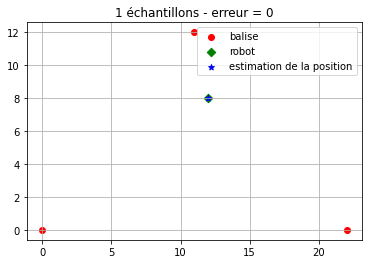

In [5]:
balises = balisess[:3]

balises_MC = []
for _ in range(1):
    balises_MC.append(balises)

d = afficher_mc(balises_MC, qreel=qreel, erreur=0)

### Erreur = 0.1
Avec une erreur de 0.1, on peut refaire le calcul autant de fois qu'on veut, on remarque que la position calculé est assez éloigné de la position réelle.

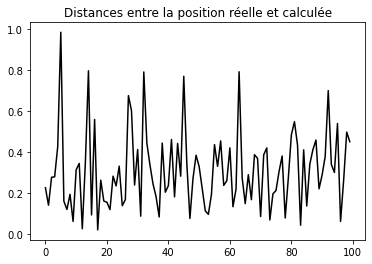

In [6]:
balises_MC = []
balises = balisess[:3]
for _ in range(1):
    balises_MC.append(balises)

distances = []
n = 100
for _ in range(n):
    distances.append(abs(np.linalg.norm(np.array(qreel) - np.array(afficher_mc(balises_MC, qreel=qreel, erreur=0.1, afficher=False)))))

plt.figure()
plt.title("Distances entre la position réelle et calculée")
plt.plot(range(n), distances, 'k')
plt.show()

### Erreur = 0.25
Avec une erreur de 0.25, on peut refaire le calcul autant de fois qu'on veut, on remarque que la position calculé est assez éloigné de la position réelle.
Et cette fois, la position est encore plus éloigné qu'avec une erreur à 0.1

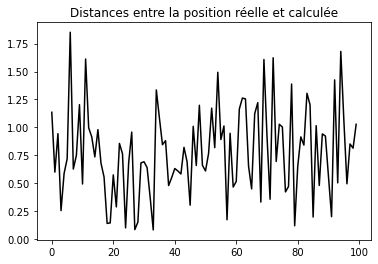

In [7]:
balises_MC = []
balises = balisess[:3]
for _ in range(1):
    balises_MC.append(balises)

distances = []
n = 100
for _ in range(n):
    distances.append(abs(np.linalg.norm(np.array(qreel) - np.array(afficher_mc(balises_MC, qreel=qreel, erreur=0.25, afficher=False)))))

plt.figure()
plt.title("Distances entre la position réelle et calculée")
plt.plot(range(n), distances, 'k')
plt.show()

### Erreur entre 0 et 1
En faisant évoluer l'erreur entre 0 et 1, on remarque que + l'erreur augmente, + la distance entre la position mesurée et réelle est élevée.

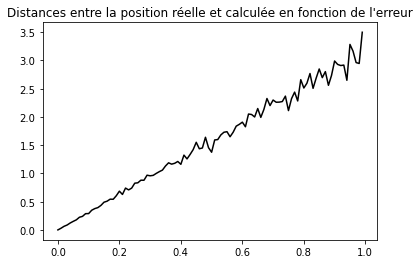

In [8]:
balises_MC = []
balises = balisess[:3]
for _ in range(1):
    balises_MC.append(balises)

distancess = []
erreurs = np.arange(0, 1, 0.01)
for erreur in erreurs:
    distances = []
    n = 100
    for _ in range(n):
        distances.append(abs(np.linalg.norm(np.array(qreel) - np.array(afficher_mc(balises_MC, qreel=qreel, erreur=erreur, afficher=False)))))
    distancess.append(np.mean(distances))

plt.figure()
plt.title("Distances entre la position réelle et calculée en fonction de l'erreur")
plt.plot(erreurs, distancess, 'k')
plt.show()

### Impact du nombre de mesures
On fait augmenter le nombre de mesure entre 1 et 200, on observe que + on mesure, + le résultat est précis.

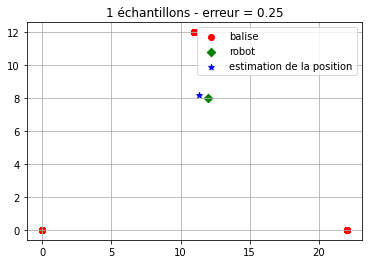

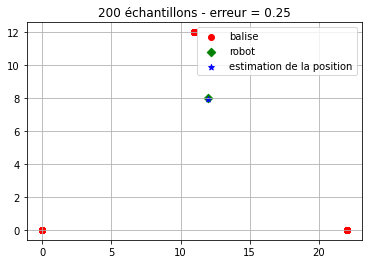

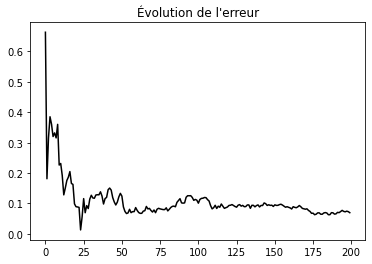

In [9]:
balises_MC = []
balises = balisess[:3]
for _ in range(200):
    balises_MC.append(balises)
afficher_mc(balises_MC, qreel=qreel, erreur=0.25)

Même avec une erreur à 0.5, on arrive à se rapprocher grandement du robot.

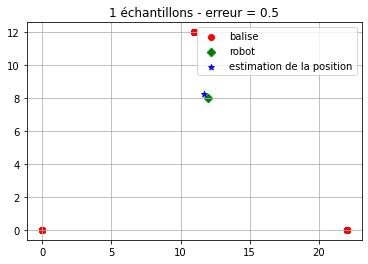

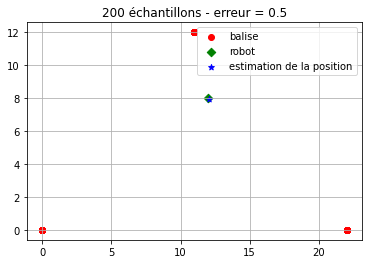

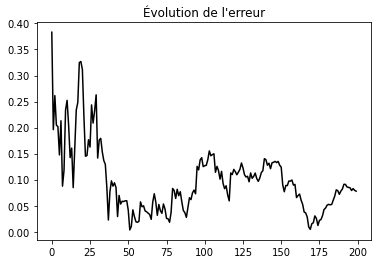

In [10]:
balises_MC = []
balises = balisess[:3]
for _ in range(200):
    balises_MC.append(balises)
afficher_mc(balises_MC, qreel=qreel, erreur=0.5)

## Impact de la position des balises
On remarque que si les balises sont "mal" positionnées, la distance entre la position réelle du robot et la position estimé reste élevé.
On peut donc en conclure que les balises doivent être placées autour du robot pour avoir un résultat optimal.

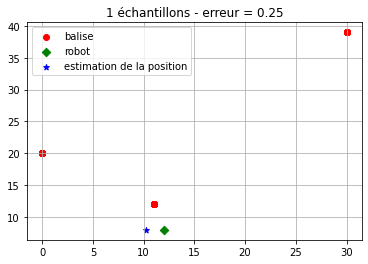

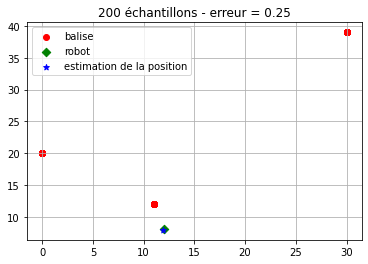

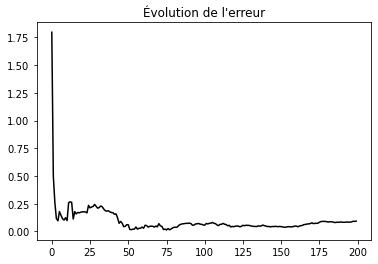

In [11]:
balises_MC = []
balises = balisess[2:5]
for _ in range(200):
    balises_MC.append(balises)
afficher_mc(balises_MC, qreel=qreel, erreur=0.25)

Avec l'expérience suivante, on peut remarquer qu'il ne faut pas non plus que les balises soient trop alignées.

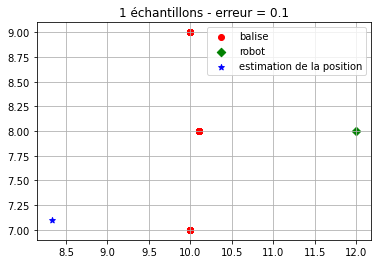

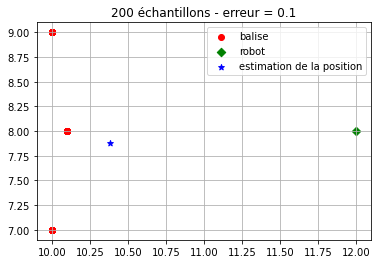

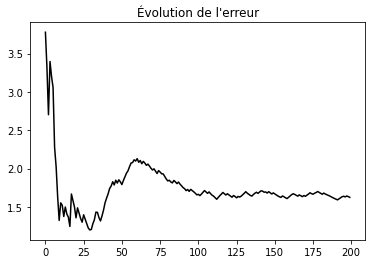

In [12]:
balises_MC = []
balises = [[10, 7], [10.1, 8], [10, 9]]
for _ in range(200):
    balises_MC.append(balises)
afficher_mc(balises_MC, qreel=qreel, erreur=0.1)

Pour conclure sur cette méthode de localisation, elle est plutôt éfficace. Cependant, il faut mesurer plusieurs fois pour arriver à un résultat correct en conditions réelles. + l'erreur est élevée, + il faut augmenter le nombre de mesure. Cela peut poser problème pour de la localisation en temps réel.
Cela est dû notamment à l'aproximation linéarisé de la fonction distance et aussi au bruit de la mesure.

In [ ]:
def mcl(B1,B2,B3,d1Mesures,d2Mesures,d3Mesures, X0):
    #Bi = [x, y]
    #Xpos = [x, y]


    # A = matrix 3*2
    # b = matrix 3*1
    # 3 balises avec position (x, y)

    A = []
    b = []

    nbMesures = len(d1Mesures)

    balises = [B1, B2, B3]
    mesures = [d1Mesures, d2Mesures, d3Mesures]
    # =============================================================================
    #     A= np.array(
    #        [
    #        [(x0-B1[0])/distQuad(Xe,B1), (y0-B1[1])/distQuad(Xe,B1)],
    #        [(x0-B2[0])/distQuad(Xe,B2), (y0-B2[1])/distQuad(Xe,B2)],
    #        [(x0-B3[0])/distQuad(Xe,B3), (y0-B3[1])/distQuad(Xe,B3)]
    #        ]
    #        )
    #
    #     # b = matrix 3*1
    #     b =np.array(
    #         [
    #         [- distQuad(Xe, B1) - (( x0*B1[0] - x0**2 + B1[1]*y0 - y0**2 ) / distQuad(Xe, B1)) + d1],
    #         [- distQuad(Xe, B2) - (( x0*B2[0] - x0**2 + B2[1]*y0 - y0**2 ) / distQuad(Xe, B2)) + d2],
    #         [- distQuad(Xe, B3) - (( x0*B3[0] - x0**2 + B3[1]*y0 - y0**2 ) / distQuad(Xe, B3)) + d3]
    #         ]
    #         )
    # =============================================================================

    for i in range(nbMesures):
        for j in (B1, B2, B3):
            A.append((X0[i][0] -j[0]/distQuad(X0[i],j), (X0[i][1]-j[1])/distQuad(X0[i],j)))

        for k in range(len(balises)):
            b.append(- distQuad(X0[i], balises[k]) - (( X0[i][0]*balises[k][0] - X0[i][0]**2 + balises[k][1]*X0[i][1] - X0[i][1]**2 ) / distQuad(X0[i], balises[k])) + mesures[k][i])

    # =============================================================================
    #     for i in range(nbMesures):
    #         A.append((X0[i][0] -B1[0]/distQuad(X0[i],B1), (X0[i][1]-B1[1])/distQuad(X0[i],B1)))
    #         A.append((X0[i][0] -B2[0]/distQuad(X0[i],B2), (X0[i][1]-B2[1])/distQuad(X0[i],B2)))
    #         A.append((X0[i][0] -B3[0]/distQuad(X0[i],B3), (X0[i][1]-B3[1])/distQuad(X0[i],B3)))
    #         b.append(- distQuad(X0[i], B1) - (( X0[i][0]*B1[0] - X0[i][0]**2 + B1[1]*X0[i][1] - X0[i][1]**2 ) / distQuad(X0[i], B1)) + d1Mesures[i])
    #         b.append(- distQuad(X0[i], B2) - (( X0[i][0]*B2[0] - X0[i][0]**2 + B2[1]*X0[i][1] - X0[i][1]**2 ) / distQuad(X0[i], B2)) + d2Mesures[i])
    #         b.append(- distQuad(X0[i], B3) - (( X0[i][0]*B3[0] - X0[i][0]**2 + B3[1]*X0[i][1] - X0[i][1]**2 ) / distQuad(X0[i], B3)) + d3Mesures[i])
    #
    #
    # =============================================================================




    A = np.matrix(A)
    b = np.matrix(b).transpose()

    At = A.transpose()
    print("A: ", A.shape)
    print("At: ", At.shape)
    print("b: ", b.shape)

    # print("At*b", np.matmul(At, b))
    # print("At*A", np.matmul(At, A))

    X = np.matmul( inv(np.matmul(At, A)),  np.matmul(At,b) )

    return X